**Using datamol - Python library that works with molecules**

**Current post**

**Key question**: Will compound 3's scaffold be similar to the scaffolds of any approved anti-infectives? 
- if similar implying it might be a good hit (with similar bacterial targets? if so this can be backed up with experimental findings from the paper, or if different targets, it might lead to a new type of anti-infective hits)

**Tasks for current post**: 
- Convert anti-infective compounds & compounds 1-3's SMILES into SELFIES (more robust for ML models) 
- Get scaffolds of the anti-infective compounds from ChEMBL + compounds 1-3 
- Get fragments of these anti-infective compounds + compounds 1-3 (?optional)
- Align compounds 1-3 with other scaffolds from ChEMBL
- Look for MCS (maximum common structure)
- Identify any similarities or differences between anti-infectives from ChEMBL and compound 3

**Features to demonstrate:**
- Using Polars dataframe library along with datamol Python library (probably a small degree only, as datamol was written with Pandas in mind only)
- Integrating experimental results from paper from PhD work into cheminformatics project (validation always crucial for computational predictions)
- Advancing from pure organic chemistry and computational chemistry without code into utilising data science tools and packages by coding in Python to direct project pathway

**Tentative future plan for next post**: - Once found scaffolds, fragments or MCS, set up a ML model as a predictive model prototype foraging for potential small molecules as anti-infective hits (random forest or other types e.g. ?XGBoost and so on) 

In [1]:
import polars as pl
import pandas as pd
import datamol as dm

In [2]:
df_ai = pl.read_csv("chembl_anti-inf.csv", separator = ";")
df_ai

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL374975""","""FUSIDIC ACID""","""ANHYDROUS FUSI…","""CEM-102|NSC-56…",4.0,"""""","""""","""1967""","""""","""""","""""","""J01XC01 | S01A…","""J01XC - Steroi…","""J01X - OTHER A…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",0,0,0,0,0,"""Unknown""","""CC(=O)O[C@H]1C…"
"""CHEMBL130""","""CHLORAMPHENICO…","""9-HYDROXY-9-PH…","""NSC-16331|NSC-…",4.0,"""Ivax Pharmaceu…","""""","""""","""""","""""","""1950""","""S01AA01 | S03A…","""S01AA - Antibi…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial;…","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,1,1,0,"""Unknown""","""O=C(N[C@H](CO)…"
"""CHEMBL186""","""CEFEPIME""","""BMY-28142|CEFE…","""BMY-28142|J01D…",4.0,"""Samson Medical…","""'cef-'""","""1987""","""cephalosporins…","""'cef-(cef-)'""","""1996""","""J01DE01""","""J01DE - Fourth…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CO/N=C(\C(=O)N…"
"""CHEMBL222645""","""FLOXACILLIN""","""ABBOFLOX|BRL 2…","""BRL 2039|BRL-2…",4.0,"""""","""'-cillin'""","""1972""","""penicillins""","""'-cillin(-cill…","""""","""J01CF05""","""J01CF - Beta-l…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,0,0,0,"""Unknown""","""Cc1onc(-c2c(F)…"
"""CHEMBL2364632""","""SARECYCLINE""","""P-005672|P0056…","""P-005672|P0056…",4.0,"""Almirall Llc""","""'-cycline'""","""2012""","""antibiotics (t…","""'-cycline(-cyc…","""2018""","""J01AA14""","""J01AA - Tetrac…","""J01A - TETRACY…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-8318706-B2""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""CON(C)Cc1ccc(O…"
"""CHEMBL62193""","""SULFADIMETHOXI…","""Madribon|NSC-6…","""NSC-683544|NSC…",4.0,"""""","""'sulfa-'""","""""","""antimicrobials…","""'sulfa-(sulfa-…","""""","""J01ED01""","""J01ED - Long-a…","""J01E - SULFONA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",0,0,0,0,0,"""Withdrawn""","""COc1cc(NS(=O)(…"
"""CHEMBL2303613""","""CEFODIZIME""","""CEFODIZIME|CEF…","""HR 221|HR 221 …",4.0,"""""","""'cef-'""","""""","""cephalosporins…","""'cef-(cef-)'""","""""","""J01DD09""","""J01DD - Third-…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""None""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",0,0,0,0,0,"""Unknown""","""CO/N=C(\C(=O)N…"
"""CHEMBL31""","""GATIFLOXACIN""","""AM-1155|BMS-20…","""AM-1155|BMS-20…",4.0,"""Apotex Inc|Bri…","""'-oxacin'""","""1997""","""antibacterials…","""'-oxacin(-oxac…","""1999""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Racemic Mixtur…",0,1,1,1,0,"""Prescription O…","""COc1c(N2CCNC(C…"
"""CHEMBL268869""","""SULFAMETHOXYPY…","""CL-13494|DEPOV…","""CL-13494|NSC-7…",4.0,"""""","""'sulfa-'""","""""","""antimicrobials…","""'sulfa-(sulfa-…","""""","""J01ED05""","""J01ED - Long-a…","""J01E - SULFONA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",0,0,0,0,0,"""Withdrawn""","""COc1ccc(NS(=O)…"


In [3]:
print(df_ai.glimpse())

Rows: 144
Columns: 29
$ Parent Molecule     <str> CHEMBL374975, CHEMBL130, CHEMBL186, CHEMBL222645, CHEMBL2364632, CHEMBL62193, CHEMBL2303613, CHEMBL31, CHEMBL268869, CHEMBL3039597
$ Name                <str> FUSIDIC ACID, CHLORAMPHENICOL, CEFEPIME, FLOXACILLIN, SARECYCLINE, SULFADIMETHOXINE, CEFODIZIME, GATIFLOXACIN, SULFAMETHOXYPYRIDAZINE, GENTAMICIN
$ Synonyms            <str> ANHYDROUS FUSIDIC ACID|CEM-102|FUCIDIN CAVIJECT|FUCITHALMIC|FUSIDATE|FUSIDIC ACID|NSC-56192|RAMYCIN|SQ 16,603|SQ-16603|TAKSTA, 9-HYDROXY-9-PHENYLXANTHENE|9-PHENYL-9H-XANTHEN-9-OL|AMPHICOL|BROCHLOR|BROLENE ANTIBIOTIC|CHLORAMPHENICOL|CHLOROFAIR|CHLOROPTIC|CHLOROPTIC S.O.P.|Chloramex|Chloramphenicol|Chlorbiotic|Chloromycetin|ECONOCHLOR|GOLDEN EYE ANTIBIOTIC|KEMICETINE|KLORAFECT|Kernispray|MYCHEL|Mychel-S|NSC-16331|NSC-3069|OPHTHOCHLOR|OPTOMYCIN|SNO PHENICOL|TUBILUX INFECTED EYES|Tevcocin|XANTHEN-9-OL, 9-PHENYL-, BMY-28142|CEFEPIME|J01DE01|Maxipime|RENAPIME|VNRX-5022, ABBOFLOX|BRL 2039|BRL-2039|CULPEN|FLOXACILLIN|

In [4]:
# Check availability types
df_ai.groupby("Availability Type").count()

Availability Type,count
str,u32
"""Prescription O…",72
"""Withdrawn""",7
"""Unknown""",29
"""Discontinued""",36


In [5]:
# Selecting only compounds that are prescription-only meds
df_ai_rx = df_ai.filter(pl.col("Availability Type") == "Prescription Only")
df_ai_rx

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL186""","""CEFEPIME""","""BMY-28142|CEFE…","""BMY-28142|J01D…",4.0,"""Samson Medical…","""'cef-'""","""1987""","""cephalosporins…","""'cef-(cef-)'""","""1996""","""J01DE01""","""J01DE - Fourth…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CO/N=C(\C(=O)N…"
"""CHEMBL2364632""","""SARECYCLINE""","""P-005672|P0056…","""P-005672|P0056…",4.0,"""Almirall Llc""","""'-cycline'""","""2012""","""antibiotics (t…","""'-cycline(-cyc…","""2018""","""J01AA14""","""J01AA - Tetrac…","""J01A - TETRACY…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-8318706-B2""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""CON(C)Cc1ccc(O…"
"""CHEMBL31""","""GATIFLOXACIN""","""AM-1155|BMS-20…","""AM-1155|BMS-20…",4.0,"""Apotex Inc|Bri…","""'-oxacin'""","""1997""","""antibacterials…","""'-oxacin(-oxac…","""1999""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Racemic Mixtur…",0,1,1,1,0,"""Prescription O…","""COc1c(N2CCNC(C…"
"""CHEMBL3039597""","""GENTAMICIN""","""GENTAMICIN|GEN…","""SCH-9724""",4.0,"""Schering Corp …","""'-micin'""","""1963""","""antibiotics (M…","""'-micin(-micin…","""1970""","""S01AA11 | S02A…","""S01AA - Antibi…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",0,0,"""Unknown""",0,0,1,1,1,"""Prescription O…","""CNC(C)[C@@H]1C…"
"""CHEMBL893""","""DICLOXACILLIN""","""BRL-1702|DICLO…","""BRL-1702|R-134…",4.0,"""Teva Pharmaceu…","""'-cillin'""","""1965""","""penicillins""","""'-cillin(-cill…","""1968""","""J01CF01""","""J01CF - Beta-l…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""Cc1onc(-c2c(Cl…"
"""CHEMBL1449""","""TICARCILLIN""","""TICARCILLIN|Ti…","""""",4.0,"""Glaxosmithklin…","""'-cillin'""","""1973""","""penicillins""","""'-cillin(-cill…","""1976""","""J01CA13""","""J01CA - Penici…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CC1(C)S[C@@H]2…"
"""CHEMBL1220""","""TINIDAZOLE""","""CP-12,574|CP-1…","""CP-12,574|CP-1…",4.0,"""Mission Pharma…","""'-nidazole'""","""1970""","""antiprotozoal …","""'-nidazole(-ni…","""2004""","""P01AB02 | J01X…","""P01AB - Nitroi…","""P01A - AGENTS …","""P01 - ANTIPROT…","""P - ANTIPARASI…","""Antiprotozoal""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",1,1,0,0,1,"""Prescription O…","""CCS(=O)(=O)CCn…"
"""CHEMBL501122""","""CEFTAROLINE FO…","""CEFTAROLINE FO…","""PPI-0903|TAK 5…",4.0,"""Apotex Inc|All…","""'cef-; fos-'""","""2006""","""cephalosporins…","""'cef-(cef-); f…","""2010""","""J01DI02""","""J01DI - Other …","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-6417175-B1""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",1,0,1,0,0,"""Prescription O…","""CCO/N=C(\C(=O)…"
"""CHEMBL137""","""METRONIDAZOLE""","""ACEA|ANABACT|B…","""BAY-5360|BAYER…",4.0,"""Inforlife Sa|L…","""'-nidazole'""","""1962""","""antiprotozoal …","""'-nidazole(-ni…","""1963""","""D06BX01 | P01A…","""D06BX - Other …","""D06B - CHEMOTH…","""D06 - ANTIBIOT…","""D - DERMATOLOG…","""Antibacterial,…","""US-6881726-B2""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",

In [6]:
# Quick overview of the statistics summary of the selected dataframe
df_ai_rx.describe()

describe,Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,f64,f64,f64,f64,f64,str,str
"""count""","""72""","""72""","""72""","""72""",72.0,"""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""","""72""",72.0,72.0,"""72""",72.0,72.0,72.0,72.0,72.0,"""72""","""72"""
"""null_count""","""0""","""0""","""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""","""0"""
"""mean""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.583333,0.0,null,0.041667,0.611111,0.694444,0.25,0.333333,null,null
"""std""",null,null,null,null,0.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.496466,0.0,null,0.201229,0.490919,0.463875,0.436051,0.474713,null,null
"""min""","""CHEMBL1082""","""AMIKACIN""","""47663|Aktob|BE…","""""",4.0,"""Alkem Laborato…","""""","""""","""""","""""","""1941""","""A01AB23 | D10A…","""A01AB - Antiin…","""A01A - STOMATO…","""A01 - STOMATOL…","""A - ALIMENTARY…","""""","""None""","""1:Synthetic Sm…",0.0,0.0,"""Achiral Molecu…",0.0,0.0,0.0,0.0,0.0,"""Prescription O…",""""""
"""max""","""CHEMBL996""","""VANCOMYCIN""","""VANCOMYCIN|Van…","""WAY-GAR-936""",4.0,"""Xiromed Pharma…","""'sulfa-'""","""2017""","""vancomycin-rel…","""'sulfa-(sulfa-…","""2019""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Inhibitor (bet…","""US-9238657-B2""","""1:Synthetic Sm…",1.0,0.0,"""Unknown""",1.0,1.0,1.0,1.0,1.0,"""Prescription O…","""O=C1CN(/N=C/c2…"
"""median""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,0.0,1.0,1.0,0.0,0.0,null,null
"""25%""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0.0,0.0,null,0.0,0.0,0.0,0.0,0.0,null,null
"""75%""",null,null,null,null,4.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.0,0.0,null,0.0,1.0,1.0,1.0,1.0,null,null


In [7]:
# Due to the error message when converting SMILES into SELFIES using datamol, 
# Attempted to spot the missing/empty SMILES
df_ai_rx.filter(pl.col("Smiles") == "")

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL3989751""","""NEOMYCIN""","""FRADIOMYCIN|KA…","""""",4.0,"""Bayer Pharmace…","""'-mycin'""","""1966""","""antibiotics (S…","""'-mycin(-mycin…","""1957""","""R02AB01 | S01A…","""R02AB - Antibi…","""R02A - THROAT …","""R02 - THROAT P…","""R - RESPIRATOR…","""""","""None""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",0,1,0,1,1,"""Prescription O…",""""""


In [8]:
# Example from StackOverflow - https://stackoverflow.com/questions/72292048/idiomatic-replacement-of-empty-string-with-pl-null-null-in-polars
# only_these = ['str1', 'str2']
# df.with_columns([
#     pl.when(pl.col(only_these).str.lengths() == 0)
#     .then(None)
#     .otherwise(pl.col(only_these))
#     .keep_name()
# ])

In [9]:
# Canonical SMILES for neomycin - C1C(C(C(C(C1N)OC2C(C(C(C(O2)CN)O)O)N)OC3C(C(C(O3)CO)OC4C(C(C(C(O4)CN)O)O)N)O)O)N
# Extracted from PubChem (https://pubchem.ncbi.nlm.nih.gov/compound/Neomycin)

df_ai_rx = df_ai_rx.with_columns([
    pl.when(pl.col("Smiles").str.lengths() == 0)
    .then("C1C(C(C(C(C1N)OC2C(C(C(C(O2)CN)O)O)N)OC3C(C(C(O3)CO)OC4C(C(C(C(O4)CN)O)O)N)O)O)N")
    .otherwise(pl.col("Smiles"))
    .keep_name()
])

df_ai_rx

Parent Molecule,Name,Synonyms,Research Codes,Phase,Drug Applicants,USAN Stem,USAN Year,USAN Definition,USAN Stem - Substem,First Approval,ATC Codes,Level 4 ATC Codes,Level 3 ATC Codes,Level 2 ATC Codes,Level 1 ATC Codes,Indication Class,Patent,Drug Type,Passes Rule of Five,First In Class,Chirality,Prodrug,Oral,Parenteral,Topical,Black Box,Availability Type,Smiles
str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,str,i64,i64,i64,i64,i64,str,str
"""CHEMBL186""","""CEFEPIME""","""BMY-28142|CEFE…","""BMY-28142|J01D…",4.0,"""Samson Medical…","""'cef-'""","""1987""","""cephalosporins…","""'cef-(cef-)'""","""1996""","""J01DE01""","""J01DE - Fourth…","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CO/N=C(\C(=O)N…"
"""CHEMBL2364632""","""SARECYCLINE""","""P-005672|P0056…","""P-005672|P0056…",4.0,"""Almirall Llc""","""'-cycline'""","""2012""","""antibiotics (t…","""'-cycline(-cyc…","""2018""","""J01AA14""","""J01AA - Tetrac…","""J01A - TETRACY…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-8318706-B2""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""CON(C)Cc1ccc(O…"
"""CHEMBL31""","""GATIFLOXACIN""","""AM-1155|BMS-20…","""AM-1155|BMS-20…",4.0,"""Apotex Inc|Bri…","""'-oxacin'""","""1997""","""antibacterials…","""'-oxacin(-oxac…","""1999""","""S01AE06 | J01M…","""S01AE - Fluoro…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Racemic Mixtur…",0,1,1,1,0,"""Prescription O…","""COc1c(N2CCNC(C…"
"""CHEMBL3039597""","""GENTAMICIN""","""GENTAMICIN|GEN…","""SCH-9724""",4.0,"""Schering Corp …","""'-micin'""","""1963""","""antibiotics (M…","""'-micin(-micin…","""1970""","""S01AA11 | S02A…","""S01AA - Antibi…","""S01A - ANTIINF…","""S01 - OPHTHALM…","""S - SENSORY OR…","""Antibacterial""","""None""","""1:Synthetic Sm…",0,0,"""Unknown""",0,0,1,1,1,"""Prescription O…","""CNC(C)[C@@H]1C…"
"""CHEMBL893""","""DICLOXACILLIN""","""BRL-1702|DICLO…","""BRL-1702|R-134…",4.0,"""Teva Pharmaceu…","""'-cillin'""","""1965""","""penicillins""","""'-cillin(-cill…","""1968""","""J01CF01""","""J01CF - Beta-l…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,1,0,0,0,"""Prescription O…","""Cc1onc(-c2c(Cl…"
"""CHEMBL1449""","""TICARCILLIN""","""TICARCILLIN|Ti…","""""",4.0,"""Glaxosmithklin…","""'-cillin'""","""1973""","""penicillins""","""'-cillin(-cill…","""1976""","""J01CA13""","""J01CA - Penici…","""J01C - BETA-LA…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""Antibacterial""","""None""","""1:Synthetic Sm…",1,0,"""Single Stereoi…",0,0,1,0,0,"""Prescription O…","""CC1(C)S[C@@H]2…"
"""CHEMBL1220""","""TINIDAZOLE""","""CP-12,574|CP-1…","""CP-12,574|CP-1…",4.0,"""Mission Pharma…","""'-nidazole'""","""1970""","""antiprotozoal …","""'-nidazole(-ni…","""2004""","""P01AB02 | J01X…","""P01AB - Nitroi…","""P01A - AGENTS …","""P01 - ANTIPROT…","""P - ANTIPARASI…","""Antiprotozoal""","""None""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",1,1,0,0,1,"""Prescription O…","""CCS(=O)(=O)CCn…"
"""CHEMBL501122""","""CEFTAROLINE FO…","""CEFTAROLINE FO…","""PPI-0903|TAK 5…",4.0,"""Apotex Inc|All…","""'cef-; fos-'""","""2006""","""cephalosporins…","""'cef-(cef-); f…","""2010""","""J01DI02""","""J01DI - Other …","""J01D - OTHER B…","""J01 - ANTIBACT…","""J - ANTIINFECT…","""""","""US-6417175-B1""","""1:Synthetic Sm…",0,0,"""Single Stereoi…",1,0,1,0,0,"""Prescription O…","""CCO/N=C(\C(=O)…"
"""CHEMBL137""","""METRONIDAZOLE""","""ACEA|ANABACT|B…","""BAY-5360|BAYER…",4.0,"""Inforlife Sa|L…","""'-nidazole'""","""1962""","""antiprotozoal …","""'-nidazole(-ni…","""1963""","""D06BX01 | P01A…","""D06BX - Other …","""D06B - CHEMOTH…","""D06 - ANTIBIOT…","""D - DERMATOLOG…","""Antibacterial,…","""US-6881726-B2""","""1:Synthetic Sm…",1,0,"""Achiral Molecu…",

In [10]:
# Keeping only two columns with information needed for later use
df_ai_rx = df_ai_rx.select(["Name", "Smiles"])
df_ai_rx.head()

Name,Smiles
str,str
"""CEFEPIME""","""CO/N=C(\C(=O)N…"
"""SARECYCLINE""","""CON(C)Cc1ccc(O…"
"""GATIFLOXACIN""","""COc1c(N2CCNC(C…"
"""GENTAMICIN""","""CNC(C)[C@@H]1C…"
"""DICLOXACILLIN""","""Cc1onc(-c2c(Cl…"


In [11]:
# Change column name of "Smiles" - to ensure the _preprocess function will work
# as smiles_column = "smiles" with lowercase "s" since will be using this function
# to cater for the 3 FtsZ compounds as well
df_ai_rx = df_ai_rx.rename({"Smiles": "smiles"})
df_ai_rx.head()

Name,smiles
str,str
"""CEFEPIME""","""CO/N=C(\C(=O)N…"
"""SARECYCLINE""","""CON(C)Cc1ccc(O…"
"""GATIFLOXACIN""","""COc1c(N2CCNC(C…"
"""GENTAMICIN""","""CNC(C)[C@@H]1C…"
"""DICLOXACILLIN""","""Cc1onc(-c2c(Cl…"


In [12]:
# Convert polars dataframe into a pandas dataframe (as datamol was only compatible with Pandas for now)
df_ai_pd = df_ai_rx.to_pandas()
df_ai_pd

,Name,smiles
0,CEFEPIME,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...
1,SARECYCLINE,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...
2,GATIFLOXACIN,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...
3,GENTAMICIN,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...
4,DICLOXACILLIN,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...
...,...,...
67,BENZYLPENICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...
68,CIPROFLOXACIN,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O
69,NORFLOXACIN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21
70,SULFANILAMIDE,Nc1ccc(S(N)(=O)=O)cc1


In [13]:
# Check the dataframe has been converted from Polars to Pandas
type(df_ai_pd)

pandas.core.frame.DataFrame

In [14]:

# Pre-process molecules using _preprocess function - adapted with courtesy from datamol.io

smiles_column = "smiles"

dm.disable_rdkit_log()

def _preprocess(row):
    mol = dm.to_mol(row[smiles_column], ordered=True)
    mol = dm.fix_mol(mol)
    mol = dm.sanitize_mol(mol, sanifix=True, charge_neutral=False)
    mol = dm.standardize_mol(
        mol,
        disconnect_metals=False,
        normalize=True,
        reionize=True,
        uncharge=False,
        stereo=True,
    )

    row["standard_smiles"] = dm.standardize_smiles(dm.to_smiles(mol))
    row["selfies"] = dm.to_selfies(mol)
    row["inchi"] = dm.to_inchi(mol)
    row["inchikey"] = dm.to_inchikey(mol)
    return row

In [15]:
# Issue found with one compound that acutally had no SMILES recorded in the dataframe!
# **Fixed by adding the missing SMILES for neomycin**

# Two methods to convert SMILES into SELFIES

# Method one - using lambda function:
# df_ai_pd["selfies"] = df_ai_pd["Smiles"].apply(lambda x: dm.to_selfies(x))
# df_ai_pd

# Method two - using _preprocess function:
data_mol_clean = df_ai_pd.apply(_preprocess, axis = 1)
data_mol_clean

,Name,smiles,standard_smiles,selfies,inchi,inchikey
0,CEFEPIME,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)[O-])=C(C[N...,[C][O][/N][=C][Branch2][Ring2][#Branch2][\C][=...,InChI=1S/C19H24N6O5S2/c1-25(5-3-4-6-25)7-10-8-...,HVFLCNVBZFFHBT-ZKDACBOMSA-N
1,SARECYCLINE,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,CON(C)Cc1ccc(O)c2c1C[C@H]1C[C@H]3[C@H](N(C)C)C...,[C][O][N][Branch1][C][C][C][C][=C][C][=C][Bran...,InChI=1S/C24H29N3O8/c1-26(2)18-13-8-11-7-12-10...,PQJQFLNBMSCUSH-SBAJWEJLSA-N
2,GATIFLOXACIN,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,COc1c(N2CCNC(C)C2)c(F)cc2c(=O)c(C(=O)O)cn(C3CC...,[C][O][C][=C][Branch1][N][N][C][C][N][C][Branc...,InChI=1S/C19H22FN3O4/c1-10-8-22(6-5-21-10)16-1...,XUBOMFCQGDBHNK-UHFFFAOYSA-N
3,GENTAMICIN,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,CNC(C)[C@@H]1CC[C@@H](N)[C@@H](O[C@H]2[C@H](O)...,[C][N][C][Branch1][C][C][C@@H1][C][C][C@@H1][B...,InChI=1S/C21H43N5O7.C20H41N5O7.C19H39N5O7/c1-9...,NPEFREDMMVQEPL-RWPARATISA-N
4,DICLOXACILLIN,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,Cc1onc(-c2c(Cl)cccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[...,[C][C][O][N][=C][Branch1][=N][C][=C][Branch1][...,InChI=1S/C19H17Cl2N3O5S/c1-7-10(12(23-29-7)11-...,YFAGHNZHGGCZAX-JKIFEVAISA-N
...,...,...,...,...,...,...
67,BENZYLPENICILLIN,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,[C][C][Branch1][C][C][S][C@@H1][C@H1][Branch1]...,InChI=1S/C16H18N2O4S/c1-16(2)12(15(21)22)18-13...,JGSARLDLIJGVTE-MBNYWOFBSA-N
68,CIPROFLOXACIN,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,O=C(O)c1cn(C2CC2)c2cc(N3CCNCC3)c(F)cc2c1=O,[O][=C][Branch1][C][O][C][=C][N][Branch1][=Bra...,InChI=1S/C17H18FN3O3/c18-13-7-11-14(8-15(13)20...,MYSWGUAQZAJSOK-UHFFFAOYSA-N
69,NORFLOXACIN,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,CCn1cc(C(=O)O)c(=O)c2cc(F)c(N3CCNCC3)cc21,[C][C][N][C][=C][Branch1][=Branch1][C][=Branch...,InChI=1S/C16H18FN3O3/c1-2-19-9-11(16(22)23)15(...,OGJPXUAPXNRGGI-UHFFFAOYSA-N
70,SULFANILAMIDE,Nc1ccc(S(N)(=O)=O)cc1,Nc1ccc(S(N)(=O)=O)cc1,[N][C][=C][C][=C][Branch1][=Branch2][S][Branch...,"InChI=1S/C6H8N2O2S/c7-5-1-3-6(4-2-5)11(8,9)10/...",FDDDEECHVMSUSB-UHFFFAOYSA-N


In [16]:
# Selfies conversion Works for one SMILES
# selfies = dm.to_selfies("O=C(N[C@H](CO)[C@H](O)c1ccc([N+](=O)[O-])cc1)C(Cl)Cl")
# selfies

**Visualise the compounds in 2D**

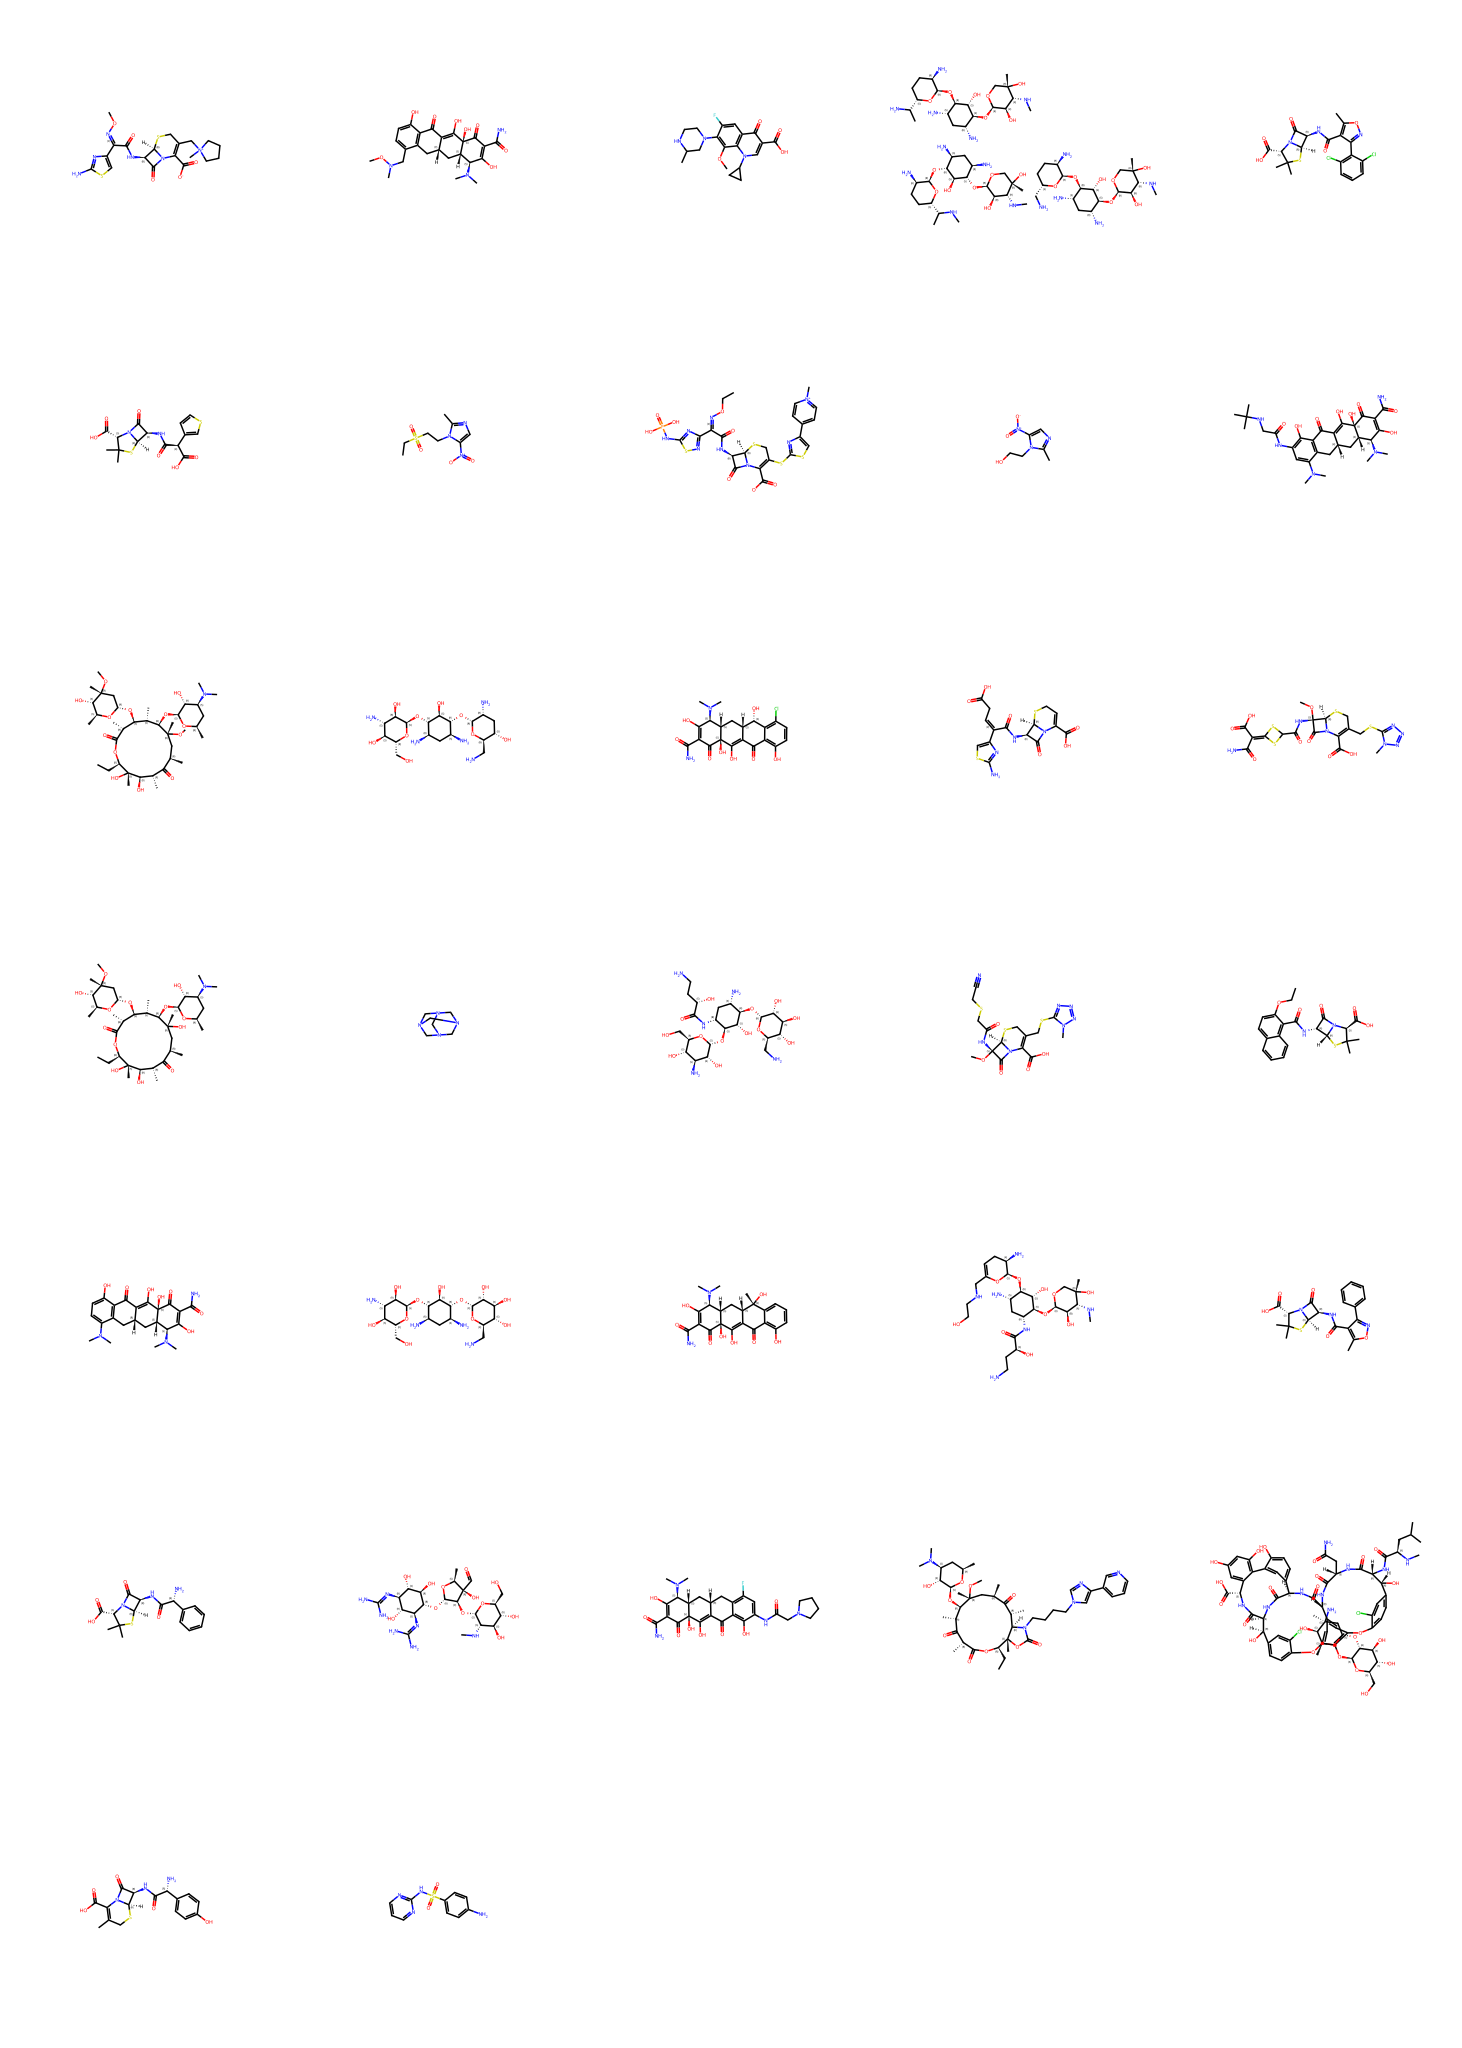

In [18]:
# Grab all SMILES from df_ai
df_ai_sm = df_ai_rx["smiles"]
# Load a list of molecules in SMILES
# dm.to_mol default set with sanitize = True
mol_ls = [dm.to_mol(smile) for smile in df_ai_sm]
# Alternative way to convert dataframe into a list of mols (same as mol_ls)
# mols = dm.from_df(df_name, smiles_column="Smiles")
# Convert the list of molecules into 2D images
dm.to_image(mol_ls, n_cols = 5, mol_size = (400, 400))

**Extract scaffolds**

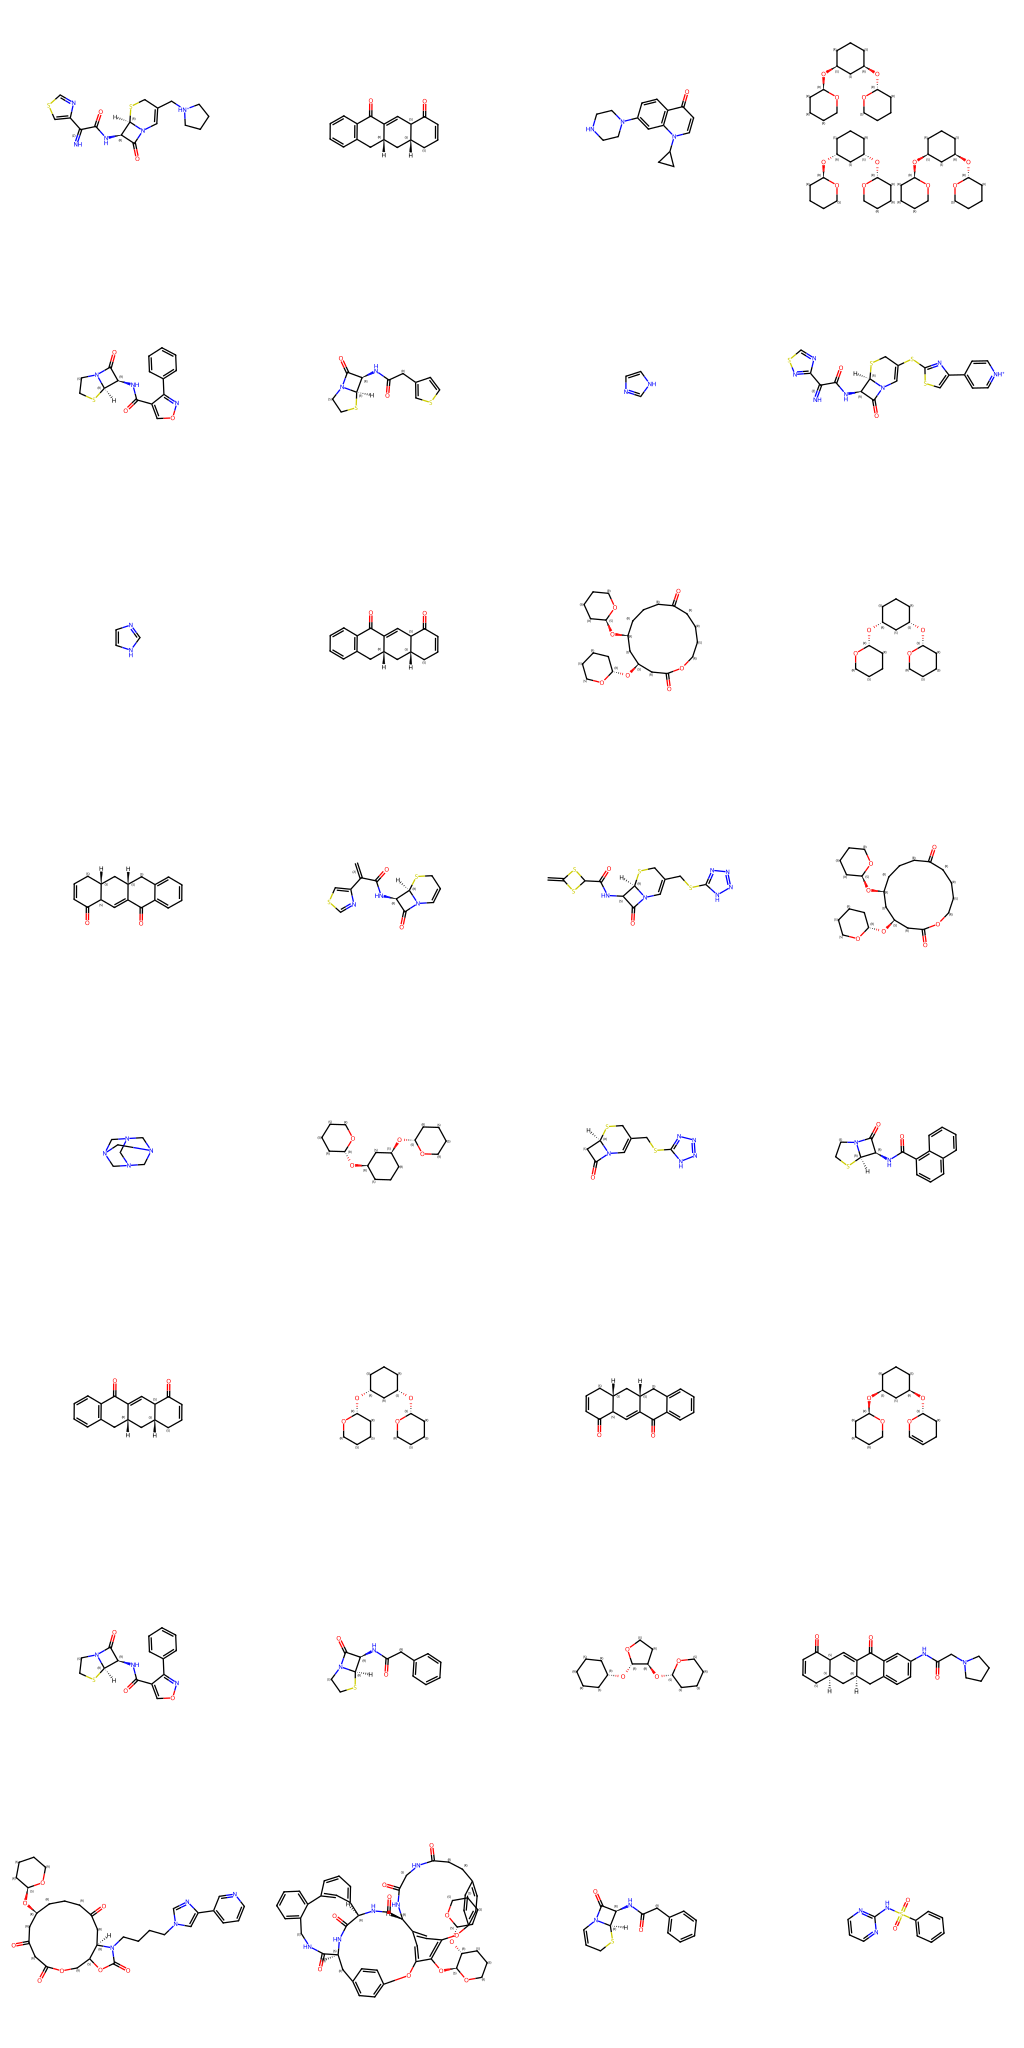

In [19]:
# Extract Murcko scaffolds from mol_ls (ChEMBL anti-infectives)
m_scaffolds = [dm.to_scaffold_murcko(mol) for mol in mol_ls]
dm.to_image(m_scaffolds, mol_size = (400, 400))

The section below focuses on 3 compounds from this paper - Lin, H.-Y.J.; Battaje, R.R.;
Tan, J.; Doddareddy, M.; Dhaked, H.P.S.; Srivastava, S.; Hawkins, B.A.; Al-Shdifat, L.M.H.; Hibbs, D.E.; Panda, D.; et al. Discovery of 2',6-Bis(4-hydroxybenzyl)-2-acetylcyclohexanone, a Novel FtsZ
Inhibitor. Molecules 2022, 27, 6993. https://doi.org/10.3390/molecules27206993

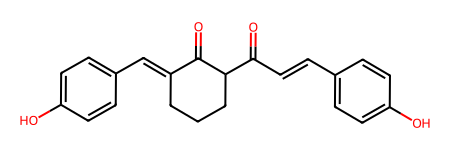

In [20]:
# Convert compound 1 to mol from InChI
cpd1 = dm.from_inchi("InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-21(25)20-3-1-2-17(22(20)26)14-16-6-11-19(24)12-7-16/h4-14,20,23-24H,1-3H2/b13-8+,17-14+")
cpd1

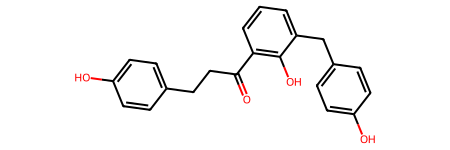

In [21]:
# Convert compound 2 SMILES to mol
cpd2 = dm.to_mol("OC1=C(C=CC=C1CC1=CC=C(C=C1)O)C(CCC1=CC=C(C=C1)O)=O")
cpd2

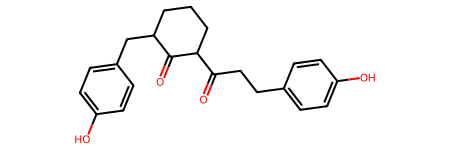

In [22]:
# Convert compound 3 SMILES to mol
cpd3 = dm.to_mol("OC1=CC=C(CC2C(C(CCC2)C(CCC2=CC=C(C=C2)O)=O)=O)C=C1")
cpd3

In [23]:
# Save these 3 compounds into a list
mol_lst = [cpd1, cpd2, cpd3]
mol_lst

In [24]:
# Convert a list of mols to a dataframe
df = dm.to_df(mol_lst)
df

/Users/jenniferlin/Scaffolds data prep/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,smiles
0,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O
1,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O
2,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O


In [25]:
names = ["Compound 1", "Compound 2", "Compound 3"]
df["names"] = names
df

,smiles,names
0,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,Compound 1
1,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,Compound 2
2,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O,Compound 3


In [26]:
data_cleaned = df.apply(_preprocess, axis=1)
data_cleaned

,smiles,names,standard_smiles,selfies,inchi,inchikey
0,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,Compound 1,O=C(/C=C/c1ccc(O)cc1)C1CCC/C(=C\c2ccc(O)cc2)C1=O,[O][=C][Branch1][=C][/C][=C][/C][=C][C][=C][Br...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,QNBFRAOWJNMPAF-ZIQQYUHESA-N
1,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,Compound 2,O=C(CCc1ccc(O)cc1)c1cccc(Cc2ccc(O)cc2)c1O,[O][=C][Branch1][=C][C][C][C][=C][C][=C][Branc...,InChI=1S/C22H20O4/c23-18-9-4-15(5-10-18)8-13-2...,CWVXMBYGWRWONE-UHFFFAOYSA-N
2,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O,Compound 3,O=C(CCc1ccc(O)cc1)C1CCCC(Cc2ccc(O)cc2)C1=O,[O][=C][Branch1][=C][C][C][C][=C][C][=C][Branc...,InChI=1S/C22H24O4/c23-18-9-4-15(5-10-18)8-13-2...,KWPXNGBFYRHREW-UHFFFAOYSA-N
